In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import torch
from torchvision import transforms as xfms

from model import UNet

In [2]:
HU_CLIP = [-900, 100]
IMG_SIZE = 512
NET_SIZE = 448
MEAN = 0.36
STD = 0.42
XFM_COMP = xfms.Compose(
    [xfms.ToTensor(),
     xfms.Resize((IMG_SIZE, IMG_SIZE)),
     xfms.CenterCrop((NET_SIZE, NET_SIZE)),
     xfms.Normalize(MEAN, STD)])


In [3]:
def preprocess(patientDicomPath, xfmComp=XFM_COMP):
    # Load all the DICOM files from a single folder into a list of 3D images and return the numpy array by simpleITK
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(patientDicomPath)
    reader.SetFileNames(dicom_names)
    img_itk = reader.Execute()
    img_3dnp = sitk.GetArrayFromImage(img_itk)

    slice_filter = (999, 0)
    for i, img in enumerate(img_3dnp):
        pc, _ = cv2.findContours(np.array(img > -150, np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        sapc = sorted(map(cv2.contourArea, pc), reverse=True)
        if sapc[1] > 1e4 or sapc[2] > 1.5e3:
            slice_filter = (min(slice_filter[0], i), max(slice_filter[1], i))

    img_3dnp = img_3dnp[slice_filter[0]:slice_filter[1]]
    img_3dnp = np.clip(img_3dnp, HU_CLIP[0], HU_CLIP[1])  # clip HU values
    img_3dnp = img_3dnp.astype(np.float32)
    img_3dnp = (img_3dnp - HU_CLIP[0]) / (HU_CLIP[1] - HU_CLIP[0])  # normalize to [0, 1]

    img_4dnp = torch.stack([XFM_COMP(img_3dnp[i]) for i in range(img_3dnp.shape[0])])

    return img_4dnp, img_itk, slice_filter

In [4]:
def evaluate(net, input4Dtensor, batchSize=8):
    torch.cuda.set_device(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

    net.to(device).eval()
    with torch.no_grad():
        output = torch.cat(
            [net(input4Dtensor[i:i + batchSize].to(device)) for i in range(0, input4Dtensor.shape[0], batchSize)], dim=0)
    return output

In [5]:
def postprocess(output, threshold=0.5):
    output = output.cpu()
    output = torch.sigmoid(output)

    msk_3d = np.zeros((output.shape[0], IMG_SIZE, IMG_SIZE))

    print(output.shape)

    diff_size = (IMG_SIZE - NET_SIZE) // 2
    for i, pp in enumerate(output):
        pc, _ = cv2.findContours(np.array(pp[0] > threshold, np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        for c in pc:
            if cv2.contourArea(c) > 500:
                cv2.fillPoly(msk_3d[i], [c + 32], 1)

    return msk_3d

In [6]:
def draw(img3D, msk3D, show=False, save=False, save_path=None, window=(-1000, 200)):
    pos_pairs = []
    for i, (x, y) in enumerate(zip(img3D, msk3D)):
        if np.sum(y) > 0:
            pos_pairs.append((i, x, y))

    d = len(pos_pairs)
    di, dj = [[j, j + i] for j in range(d) for i in range(2) if j**2 + i * j > d][0]
    fig = plt.figure(figsize=(min(dj * 4, 24), min(di * 4, 24)))
    for i, (idx, img, msk) in enumerate(pos_pairs):
        ax = fig.add_subplot(di, dj, i + 1)
        ax.imshow(img, cmap='bone', vmin=window[0], vmax=window[1])
        pc, _ = cv2.findContours(np.array(msk > .5, np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        for c in pc:
            plt.plot(c[:, 0, 0], c[:, 0, 1], color="yellow")
        ax.set_title(f"slice {idx}, area {np.sum(msk)}")
        # pc, _ = cv2.findContours(np.array(img > -150, np.uint8) , cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        # pc = sorted(pc, key=lambda x: cv2.contourArea(x), reverse=True)
        # for c in pc:
        #     plt.plot(c[:, 0, 0], c[:, 0, 1], color="red")
        # ax.set_title(f"slice {idx}, {cv2.contourArea(pc[0])}\n{[cv2.contourArea(c) for c in pc[1:4]]}")
        ax.axis('off')
    if save and save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()
    return


In [7]:
def draw_gt(img3D, msk3D, gt3D, show=False, save=False, save_path=None, window=(-1000, 200)):
    COLORS = ['#FF5733', '#4CAF50', '#4287f5', '#FFC300', '#E040FB', '#FF9933', '#5C5C5C', '#FF66CC', '#00BFFF', '#FF1493']
    pos_pairs = []
    for i, (x, y, Y) in enumerate(zip(img3D, msk3D, gt3D)):
        if np.sum(y) > 0:
            pos_pairs.append((i, x, y, Y))

    d = len(pos_pairs)
    di, dj = (9, 9) # [[j, j + i] for j in range(d) for i in range(2) if j**2 + i * j > d][0]
    fig = plt.figure(figsize=(min(dj * 4, 24), min(di * 4, 24)))
    for i, (idx, img, msk, gt) in enumerate(pos_pairs):
        ax = fig.add_subplot(di, dj, i + 1)
        ax.imshow(img, cmap='bone', vmin=window[0], vmax=window[1])
        pc, _ = cv2.findContours(np.array(msk == 4, np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        for c in pc:
            plt.plot(c[:, 0, 0], c[:, 0, 1], color="yellow")
        pc, _ = cv2.findContours(np.array(gt == 9, np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        for c in pc:
            plt.plot(c[:, 0, 0], c[:, 0, 1], color="red")
        ax.set_title(f"slice {idx}, area {np.sum(msk)}")
        ax.axis('off')
    if save and save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()
    return


In [8]:
def toNRRD(pixels, path, affine):
    # pixels: 3D numpy array
    # path: save path
    # infos: dict
    img_itk = sitk.GetImageFromArray(pixels)
    img_itk.SetSpacing(affine['spacing'])
    img_itk.SetOrigin(affine['origin'])
    img_itk.SetDirection(affine['direction'])

    sitk.WriteImage(img_itk, path)
    print(f"saved to {path}")
    return


def save_NRRDs(img3d, msk3d, path, info):
    affine = {
        'spacing': (info['spacing'][0], info['spacing'][1], info['thickness']),
        'origin': info['position'],
        'direction': (1, 0, 0, 0, 1, 0, 0, 0, -1)
    }

    os.makedirs(os.path.dirname(path), exist_ok=True)
    toNRRD(img3d, os.path.join(f"{path}.nrrd"), affine)
    toNRRD(np.concatenate(
        [np.zeros(info['frontShape']), msk3d, np.zeros(info['backShape'])], axis=0), os.path.join(f"{path}.seg.nrrd"), affine)

    return

In [9]:
def inference(net=UNet(nbClasses=1, outSize=(NET_SIZE, NET_SIZE)),
              weightPath=None,
              patientDicomPath="RP-2019-46p111ct/000218422H_20191128",
              groundTruthNiiPath=None,
              batchSize=8,
              window=(-1000, 200),
              savePath=None):
    if weightPath is not None:
        state_dict = torch.load(weightPath, map_location=torch.device('cpu'))
        moderfied_state_dict = {}
        for key, value in state_dict.items():
            if key.startswith('module.'):  # 删除"module."前缀
                new_key = key[7:]
            else:
                new_key = key
            moderfied_state_dict[new_key] = value
        del state_dict
        net.load_state_dict(moderfied_state_dict)

    input4Dtensor, img_itk, slice_filter = preprocess(patientDicomPath)
    output = evaluate(net, input4Dtensor, batchSize)
    mask = postprocess(output)

    draw(sitk.GetArrayFromImage(img_itk)[slice_filter[0]:slice_filter[1]],
         mask,
         show=True,
         save=savePath is not None,
         save_path=savePath,
         window=window)
    return mask

device 0 NVIDIA GeForce RTX 3090
torch.Size([51, 1, 448, 448])


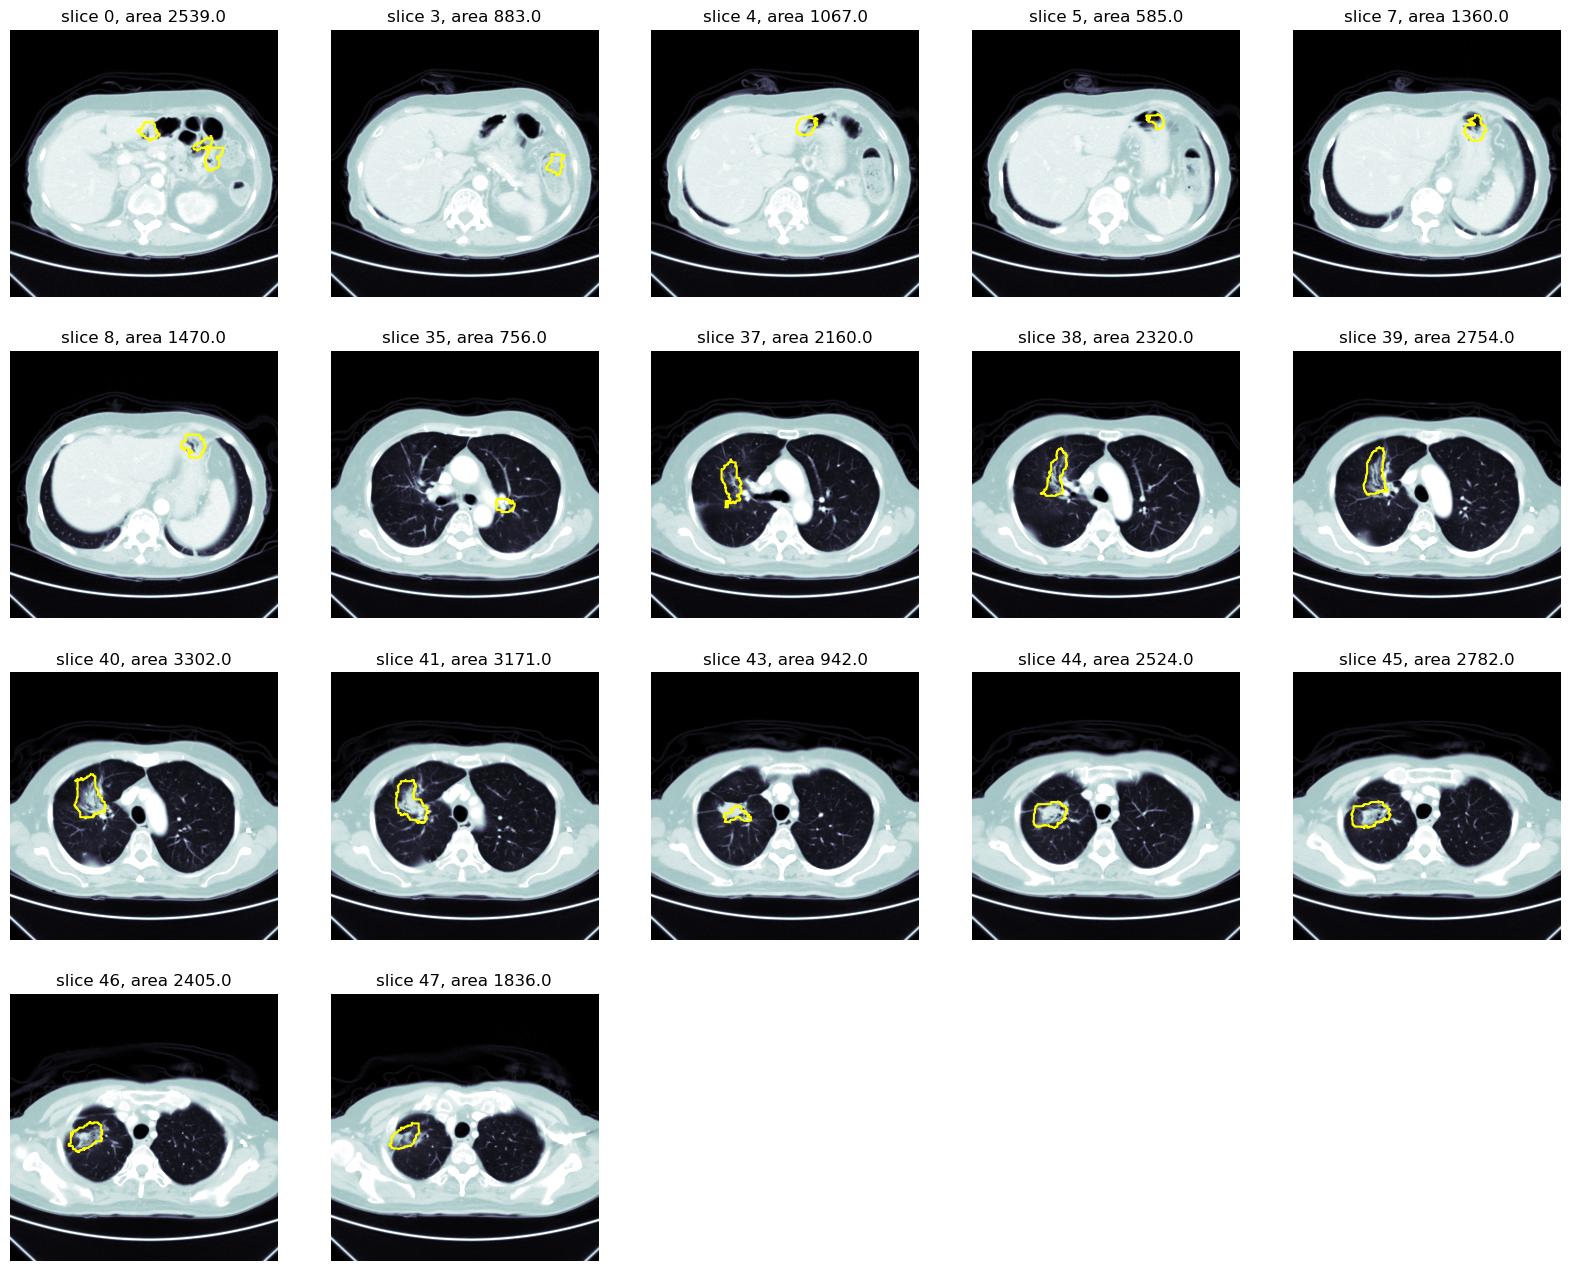

In [10]:
msk = inference(weightPath='/root/projs/rili/RILI-2019-2020/expD/0.4382_118.pth'
                )  #, patientDicomPath='/root/projs/rili/RILI-2019-2020/RP-2019-46p111ct/000385021D_20191112')
